## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import imageio
import sklearn.model_selection
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, precision_score, recall_score, accuracy_score 

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Do some early processing of your metadata for easier model training:

In [3]:
#data_dir = '/data' # udacity workspace
data_dir = '/home/matthias/data/udacity/pneumonia' # local


In [4]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv(os.path.join(data_dir,'Data_Entry_2017.csv'))
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join(data_dir,'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
13411,00003490_001.png,No Finding,1,3490,56,F,AP,2500,2048,0.171,0.171,NaN,/home/matthias/data/udacity/pneumonia/images_0...
62696,00015530_024.png,Infiltration,24,15530,20,M,AP,3056,2544,0.139,0.139,NaN,/home/matthias/data/udacity/pneumonia/images_0...
69370,00017122_000.png,Nodule,0,17122,75,F,PA,2422,2991,0.143,0.143,NaN,/home/matthias/data/udacity/pneumonia/images_0...


In [5]:
all_xray_df = all_xray_df[all_xray_df['Patient Age'] < 100]

In [6]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
# split findings
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
52706,00013285_039.png,Edema,39,13285,17,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42516,00010938_002.png,No Finding,2,10938,32,F,PA,2810,2781,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10167,00002639_004.png,No Finding,4,2639,75,F,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: "pneumonia" if x==1 else "no pneumonia")

In [8]:
# add image_path
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join(data_dir,'images*', '*', '*.png'))}
all_xray_df['image_path'] = all_xray_df['Image Index'].map(all_image_paths)

In [9]:
all_xray_df[['image_path', 'Image Index']]

,image_path,Image Index
0,/home/matthias/data/udacity/pneumonia/images_0...,00000001_000.png
1,/home/matthias/data/udacity/pneumonia/images_0...,00000001_001.png
2,/home/matthias/data/udacity/pneumonia/images_0...,00000001_002.png
3,/home/matthias/data/udacity/pneumonia/images_0...,00000002_000.png
4,/home/matthias/data/udacity/pneumonia/images_0...,00000003_000.png
...,...,...
112115,/home/matthias/data/udacity/pneumonia/images_0...,00030801_001.png
112116,/home/matthias/data/udacity/pneumonia/images_0...,00030802_000.png
112117,/home/matthias/data/udacity/pneumonia/images_0...,00030803_000.png
112118,/home/matthias/data/udacity/pneumonia/images_0...,00030804_000.png


In [10]:
# ratio of patients with pneumonia
all_xray_df_unique_patient = all_xray_df.groupby('Patient ID').first()

In [11]:
all_xray_df_unique_patient.pneumonia_class.value_counts()

no pneumonia    30625
pneumonia         177
Name: pneumonia_class, dtype: int64

## Create your training and testing data:

In [12]:
# Number of pneumonia and non-pneumonia cases
all_xray_df.pneumonia_class.value_counts()

no pneumonia    110674
pneumonia         1430
Name: pneumonia_class, dtype: int64

In [13]:
def create_splits(all_xray_df, val_size=0.1, test_size=0.2, train_neg_factor = 1, test_neg_factor = None):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    train, test = sklearn.model_selection.train_test_split(all_xray_df,test_size=test_size,stratify = all_xray_df['pneumonia_class'])
    train_pos_sample = train[train.pneumonia_class == "pneumonia"]
    train_neg_sample = train[train.pneumonia_class== "no pneumonia"].sample(len(train_pos_sample) * train_neg_factor)
    train_balanced = pd.concat([train_neg_sample, train_pos_sample], axis=0)
    
    # get separate validation set of early stoping and hyperparameter tuning
    train_final, val_final = sklearn.model_selection.train_test_split(train_balanced,test_size=val_size,stratify = train_balanced['pneumonia_class'])
    
    # no further information on real world distribution to adjust validation set
    if test_neg_factor:
        test_pos_sample = test[test.pneumonia_class == "pneumonia"]
        test_neg_sample = test[test.pneumonia_class== "no pneumonia"].sample(len(test_pos_sample) * test_neg_factor)
        test_balanced = pd.concat([test_pos_sample, test_neg_sample], axis=0) 
    else:
        test_balanced = test
    
    return train_final, val_final, test_balanced

In [14]:
train, val, test = create_splits(all_xray_df)

In [15]:
train.pneumonia_class.value_counts()

pneumonia       1030
no pneumonia    1029
Name: pneumonia_class, dtype: int64

In [16]:
val.pneumonia_class.value_counts()

no pneumonia    115
pneumonia       114
Name: pneumonia_class, dtype: int64

In [17]:
test.pneumonia_class.value_counts()

no pneumonia    22135
pneumonia         286
Name: pneumonia_class, dtype: int64

In [18]:
# check images paths are correctly assigned
val[['Image Index', 'image_path', 'Pneumonia', 'pneumonia_class']]

,Image Index,image_path,Pneumonia,pneumonia_class
64046,00015807_001.png,/home/matthias/data/udacity/pneumonia/images_0...,0.0,no pneumonia
2879,00000766_005.png,/home/matthias/data/udacity/pneumonia/images_0...,1.0,pneumonia
69749,00017191_001.png,/home/matthias/data/udacity/pneumonia/images_0...,1.0,pneumonia
60220,00014871_006.png,/home/matthias/data/udacity/pneumonia/images_0...,1.0,pneumonia
60901,00015034_001.png,/home/matthias/data/udacity/pneumonia/images_0...,0.0,no pneumonia
...,...,...,...,...
64949,00016036_004.png,/home/matthias/data/udacity/pneumonia/images_0...,1.0,pneumonia
89320,00022178_000.png,/home/matthias/data/udacity/pneumonia/images_0...,1.0,pneumonia
107262,00028940_005.png,/home/matthias/data/udacity/pneumonia/images_0...,1.0,pneumonia
44006,00011355_007.png,/home/matthias/data/udacity/pneumonia/images_0...,0.0,no pneumonia


In [19]:
# TODO additional option: downsample in training set per person to improve diversity

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [20]:
def my_image_augmentation( horizontal_flip = False, height_shift_range = 0, width_shift_range = 0,
                         rotation_range = 0, brightness_range = None, shear_range = 0.0, zoom_range= 0.0):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              samplewise_std_normalization = True,
                              horizontal_flip = horizontal_flip, 
                              vertical_flip = False, 
                              height_shift_range = height_shift_range, 
                              width_shift_range = width_shift_range, 
                              rotation_range = rotation_range,
                              brightness_range = brightness_range, # list of floats 
                              shear_range = shear_range,
                              zoom_range= zoom_range
                        )


    return my_idg


def make_train_gen(train, target_size, batch_size, horizontal_flip = True, height_shift_range = 0.1, width_shift_range = 0.1,
                         rotation_range = 20, brightness_range = (0.9,1), shear_range = 0.1, zoom_range= 0.3):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    idg = my_image_augmentation(horizontal_flip = horizontal_flip, height_shift_range = height_shift_range,
                                width_shift_range = width_shift_range, rotation_range = rotation_range,
                                brightness_range = brightness_range, shear_range = shear_range, zoom_range= zoom_range)
    
    
    train_gen = idg.flow_from_dataframe(dataframe=train, 
                                             directory=None, 
                                             x_col = 'image_path',
                                             y_col = 'pneumonia_class',
                                             #color_mode='grayscale',
                                             class_mode = 'binary',
                                             target_size = target_size, 
                                             batch_size = batch_size,
                                             shuffle=True,
                                             )    
    

    return train_gen


def make_test_gen(test, target_size, batch_size):
    
    idg_val = my_image_augmentation()
    
    
    test_gen = idg_val.flow_from_dataframe(dataframe=test, 
                                             directory=None, 
                                             x_col = 'image_path',
                                             y_col = 'pneumonia_class',
                                             #color_mode='grayscale',
                                             class_mode = 'binary',
                                             target_size = target_size, 
                                             batch_size = batch_size,
                                             shuffle = False,
                                             )    

    return test_gen

In [21]:
target_size = (224, 224) 

test_gen = make_test_gen(test, target_size, batch_size = 64) 

/home/matthias/anaconda3/envs/chemtran/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 22421 validated image filenames belonging to 2 classes.


In [22]:
batch_size = 128
samplewise_std_normalization = True
horizontal_flip = True
height_shift_range = 0.1
width_shift_range = 0.1
rotation_range = 10
brightness_range = (0.9,1)
shear_range = 0.1
zoom_range= 0.1

train_gen = make_train_gen(train, target_size, batch_size = batch_size, height_shift_range = height_shift_range,
                                width_shift_range = width_shift_range, rotation_range = rotation_range,
                                brightness_range = brightness_range, shear_range = shear_range, zoom_range= zoom_range)


/home/matthias/anaconda3/envs/chemtran/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 2059 validated image filenames belonging to 2 classes.


In [23]:
## May want to pull a single large batch of random validation data for testing after each epoch:
testX, testY = test_gen.next()

In [24]:
testY

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

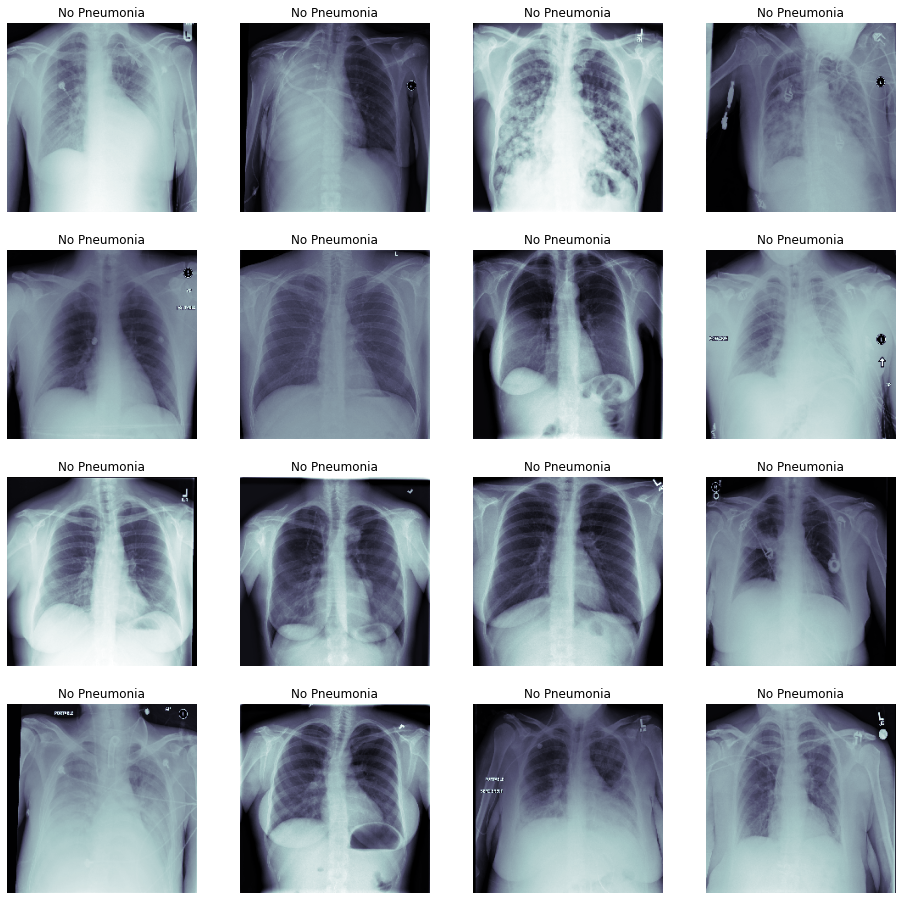

In [25]:
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(testX, testY, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

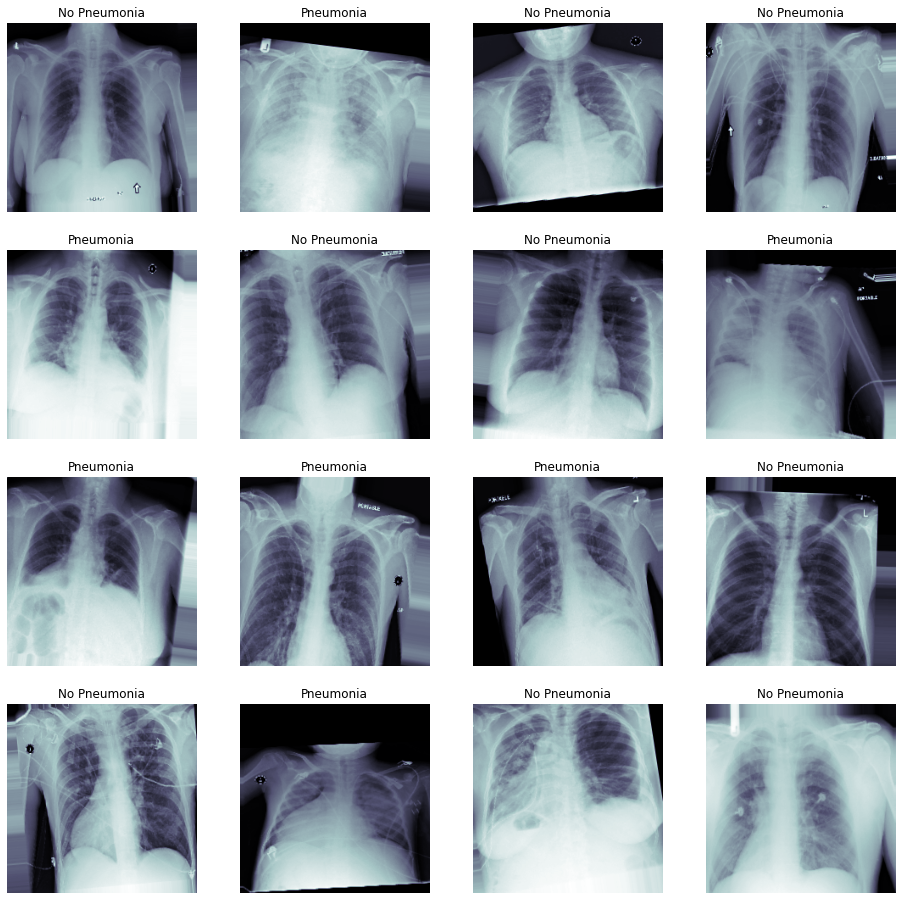

In [26]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [27]:
def load_pretrained_model():
    
    # which other preload weights on keras?
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)
    
    last_conv_layer = model.get_layer('block5_conv3')
    
    return vgg_model, last_conv_layer


In [28]:
# vgg_model, last_conv_layer = load_pretrained_model()

In [29]:
# vgg_model.summary()
# for layer in vgg_model.layers[0:15]:
#     layer.trainable = False
# for layer in vgg_model.layers:
#     print(layer.name, layer.trainable)

In [30]:
def f1_score(y_true, y_pred): 
    # implicite threshold 0.5
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [31]:
def build_model(metrics, freeze_layer_index = 17, dropout_prob = 0.5, lr = 1e-4):
    
    vgg_model, last_conv_layer = load_pretrained_model()
    
    # freezing beginning layers
    for layer in vgg_model.layers[0:freeze_layer_index]:
        layer.trainable = False
        
    model = Sequential()
    model.add(vgg_model)
    model.add(Flatten()) # whats the output dim?
    model.add(Dropout(dropout_prob))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout_prob))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_prob)) 
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    
    optimizer = Adam(lr=lr)
    loss = 'binary_crossentropy'
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
       
    return model , last_conv_layer



In [32]:
# # build model
# metrics = [keras.metrics.binary_accuracy , f1_score, keras.metrics.AUC(name='auc', num_thresholds=200)] # TODO add additional metrics

# model, last_conv_layer = build_model(metrics, freeze_layer_index = 17, dropout_prob=0.3, lr = 1e-4)


In [33]:
# model.summary()

In [34]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting


def create_call_backs(monitor_metric = 'val_loss', mode = 'min', patience=15, save_freq = 'epoch', only_save_best = False): 

    weight_path="pneunomia_weights.hdf5" 
    
    if only_save_best:
        save_freq='epoch'
    
    checkpoint = ModelCheckpoint(weight_path, 
                                 monitor= 'val_loss', 
                                 verbose=1, 
                                 save_best_only=only_save_best, 
                                 save_freq = save_freq,
                                 mode= mode, 
                                 save_weights_only = True)

    early = EarlyStopping(monitor= 'val_loss', 
                          mode= mode, 
                          patience=patience)

    callbacks_list = [checkpoint, early]
    return callbacks_list, weight_path

In [35]:
# callbacks_list, weight_path = create_call_backs()

### Start training! 

In [36]:
## train your model
# epochs = 20

# history = model.fit_generator(train_gen, 
#                           validation_data = val_gen, 
#                           epochs = epochs, 
#                           callbacks = callbacks_list)

In [37]:
# combine different steps
# data set split
val_size = 0.1
test_size = 0.2
train_neg_factor = 1 # 1
test_neg_factor = 3 # 3 assuming clinical distribution


# image augmentation
target_size = (224, 224) 
batch_size = 64
horizontal_flip = True
height_shift_range = 0.05
width_shift_range = 0.05
rotation_range = 5
brightness_range = (0.95,1)
shear_range = 0.05
zoom_range= 0.05

# model
freeze_layer_index = 17
dropout_prob = 0.5
lr = 1e-5

# training
metrics = [keras.metrics.binary_accuracy , f1_score, keras.metrics.AUC(name='auc', num_thresholds=200)] # TODO add additional metrics
monitor_metric = 'val_loss'
mode = 'min'
patience = 10
epochs = 60
save_epochs = 1
only_save_best = True


In [38]:


train, val, test = create_splits(all_xray_df, val_size, test_size, train_neg_factor, test_neg_factor)

test_gen = make_test_gen(test, target_size, batch_size = batch_size) 

train_gen = make_train_gen(train, target_size, batch_size = batch_size, 
                                height_shift_range = height_shift_range,
                                width_shift_range = width_shift_range, rotation_range = rotation_range,
                                brightness_range = brightness_range, shear_range = shear_range, zoom_range= zoom_range)
val_gen =  make_train_gen(val, target_size, batch_size = batch_size, 
                                height_shift_range = height_shift_range,
                                width_shift_range = width_shift_range, rotation_range = rotation_range,
                                brightness_range = brightness_range, shear_range = shear_range, zoom_range= zoom_range)


model, last_conv_layer = build_model(metrics, freeze_layer_index = freeze_layer_index, dropout_prob=dropout_prob, lr = lr)

batches_per_epoch = len(train) / batch_size
save_frequ = int(batches_per_epoch * save_epochs)

callbacks_list, weight_path = create_call_backs(monitor_metric = monitor_metric, mode = mode, patience=patience, save_freq=save_frequ,only_save_best = only_save_best)




/home/matthias/anaconda3/envs/chemtran/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 1144 validated image filenames belonging to 2 classes.


/home/matthias/anaconda3/envs/chemtran/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 2059 validated image filenames belonging to 2 classes.
Found 229 validated image filenames belonging to 2 classes.


/home/matthias/anaconda3/envs/chemtran/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [39]:
history = model.fit(train_gen, 
                          validation_data = val_gen, 
                          epochs = epochs, 
                          callbacks = callbacks_list,)

Epoch 1/60
33/33 [==============================] - ETA: 0s - loss: 0.8609 - binary_accuracy: 0.4910 - f1_score: 0.4413 - auc: 0.4916
Epoch 00001: val_loss improved from inf to 0.82412, saving model to pneunomia_weights.hdf5
33/33 [==============================] - 106s 3s/step - loss: 0.8609 - binary_accuracy: 0.4910 - f1_score: 0.4413 - auc: 0.4916 - val_loss: 0.8241 - val_binary_accuracy: 0.5022 - val_f1_score: 0.6694 - val_auc: 0.5421
Epoch 2/60
33/33 [==============================] - ETA: 0s - loss: 0.7912 - binary_accuracy: 0.5134 - f1_score: 0.5070 - auc: 0.5259
Epoch 00002: val_loss improved from 0.82412 to 0.74312, saving model to pneunomia_weights.hdf5
33/33 [==============================] - 44s 1s/step - loss: 0.7912 - binary_accuracy: 0.5134 - f1_score: 0.5070 - auc: 0.5259 - val_loss: 0.7431 - val_binary_accuracy: 0.5022 - val_f1_score: 0.6529 - val_auc: 0.6260
Epoch 3/60
33/33 [==============================] - ETA: 0s - loss: 0.7784 - binary_accuracy: 0.5109 - f1_score

33/33 [==============================] - ETA: 0s - loss: 0.6756 - binary_accuracy: 0.5862 - f1_score: 0.5792 - auc: 0.6261
Epoch 00020: val_loss did not improve from 0.64548
33/33 [==============================] - 44s 1s/step - loss: 0.6756 - binary_accuracy: 0.5862 - f1_score: 0.5792 - auc: 0.6261 - val_loss: 0.6506 - val_binary_accuracy: 0.6288 - val_f1_score: 0.6601 - val_auc: 0.6809
Epoch 21/60
33/33 [==============================] - ETA: 0s - loss: 0.6854 - binary_accuracy: 0.5716 - f1_score: 0.5535 - auc: 0.6090
Epoch 00021: val_loss did not improve from 0.64548
33/33 [==============================] - 44s 1s/step - loss: 0.6854 - binary_accuracy: 0.5716 - f1_score: 0.5535 - auc: 0.6090 - val_loss: 0.6500 - val_binary_accuracy: 0.6376 - val_f1_score: 0.6607 - val_auc: 0.6873
Epoch 22/60
33/33 [==============================] - ETA: 0s - loss: 0.6724 - binary_accuracy: 0.5881 - f1_score: 0.5935 - auc: 0.6328
Epoch 00022: val_loss did not improve from 0.64548
33/33 [=============

Epoch 40/60
33/33 [==============================] - ETA: 0s - loss: 0.6513 - binary_accuracy: 0.6207 - f1_score: 0.6132 - auc: 0.6727
Epoch 00040: val_loss did not improve from 0.63658
33/33 [==============================] - 44s 1s/step - loss: 0.6513 - binary_accuracy: 0.6207 - f1_score: 0.6132 - auc: 0.6727 - val_loss: 0.6367 - val_binary_accuracy: 0.6507 - val_f1_score: 0.6704 - val_auc: 0.7039
Epoch 41/60
33/33 [==============================] - ETA: 0s - loss: 0.6328 - binary_accuracy: 0.6484 - f1_score: 0.6342 - auc: 0.6971
Epoch 00041: val_loss did not improve from 0.63658
33/33 [==============================] - 44s 1s/step - loss: 0.6328 - binary_accuracy: 0.6484 - f1_score: 0.6342 - auc: 0.6971 - val_loss: 0.6444 - val_binary_accuracy: 0.6201 - val_f1_score: 0.6489 - val_auc: 0.6904
Epoch 42/60
33/33 [==============================] - ETA: 0s - loss: 0.6442 - binary_accuracy: 0.6289 - f1_score: 0.6244 - auc: 0.6783
Epoch 00042: val_loss did not improve from 0.63658
33/33 [=

### Analyzing training

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [40]:
#Also consider plotting the history of your model training:

def plot_history(history):
    plt.figure(figsize = (9, 9))
    x = range(0,len(history.history['loss']))
    plt.plot(x, history.history['val_loss'], label = 'val_loss')
    plt.plot(x, history.history['loss'], label = 'loss')
    #plt.plot(x, history.history['val_binary_accuracy'], label = 'val_binary_accuracy')
    #plt.plot(x, history.history['binary_accuracy'], label = 'binary_accuracy')
    plt.plot(x, history.history['f1_score'], label = 'f1_score')
    plt.plot(x, history.history['val_f1_score'], label = 'val_f1_score')
    plt.xlabel('Epoch')
    plt.ylabel('Performance')

    plt.legend()

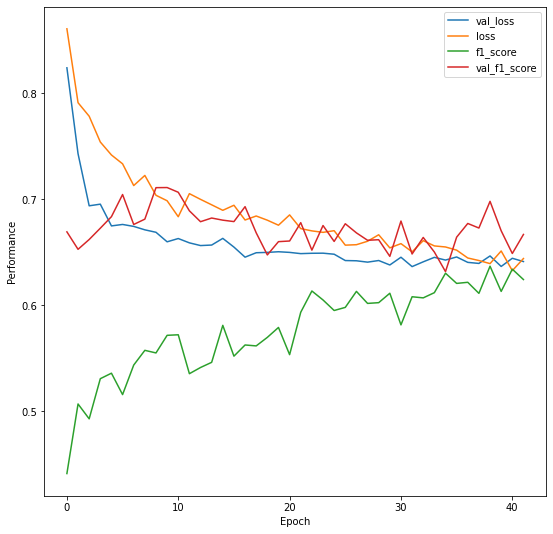

In [41]:
plot_history(history)


In [42]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model_epoch = 16
weight_path = f"pneunomia_weights.{model_epoch:02d}.hdf5" 
weight_path = "pneunomia_weights.best_2.hdf5"
model.load_weights(weight_path)


In [64]:
pred_Y = model.predict(test_gen, verbose = True)
pred_Y = pred_Y.squeeze()

18/18 [==============================] - 13s 715ms/step


In [62]:
test_Y = test.Pneumonia

In [45]:
print(pred_Y.shape)
print(test_Y.shape)

(1144,)
(1144,)


In [46]:
# function to plot the roc_curve. You can utilize roc_curve and auc imported above
def plot_roc_curve(ground_truth, probability):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresh = roc_curve(ground_truth, probability)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('FPR')
    c_ax.set_ylabel('TPR')
    
    
# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(ground_truth, probability):
    plt.figure(figsize = (9, 9))
    pr, rc, thresh =precision_recall_curve(ground_truth, probability)
    plt.plot(rc,pr, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(ground_truth,probability)))
    plt.legend()
    plt.xlabel('recall')
    plt.ylabel('precision')
    return pr, rc, thresh

# function to calculate the F1 score
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

   


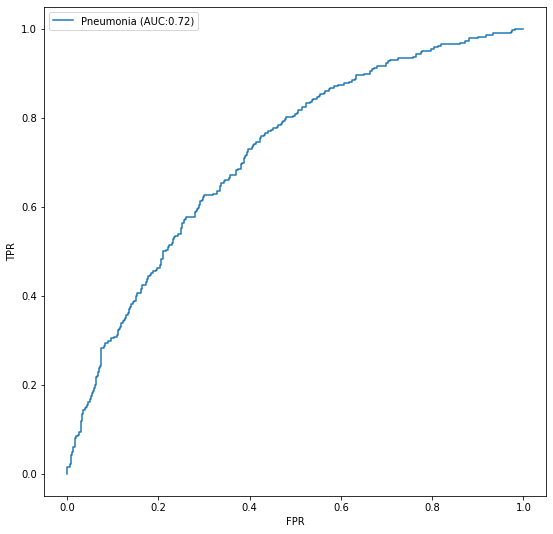

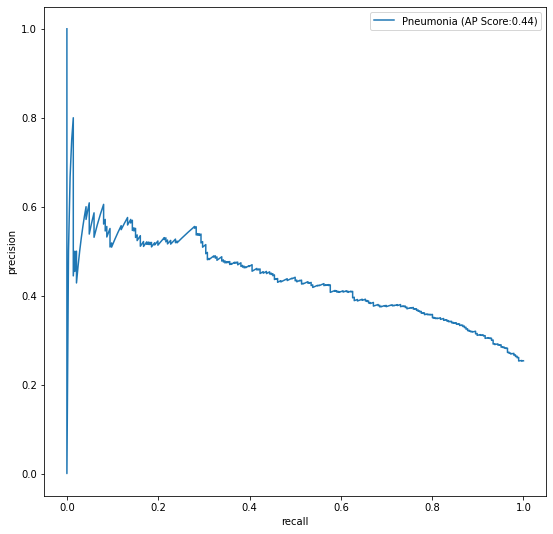

In [47]:
## plot figures
plot_roc_curve(test_Y,pred_Y)

pr, rc, thresh = plot_precision_recall_curve(test_Y,pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [48]:
precision, recall, thresholds = precision_recall_curve(test_Y,pred_Y)

In [49]:
# Look at the threshold where recall is 0.8
recall_value = 0.9
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.31076178960096734
Recall is: 0.8986013986013986
Threshold is: 0.35808104
F1 Score is: 0.4618149146451033


In [50]:
# Look at the threshold where recall is 0.8
precision_value = 0.7
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.6666666666666666
Recall is: 0.013986013986013986
Threshold is: 0.7501259
F1 Score is: 0.027397260273972605


In [51]:
f1_scores = [calc_f1(pr,rc) for pr,rc in zip(precision, recall)]

<ipython-input-46-b66ce121cb59>:23: RuntimeWarning: invalid value encountered in double_scalars
  return 2*(prec*recall)/(prec+recall)


Text(0, 0.5, 'f1 score')

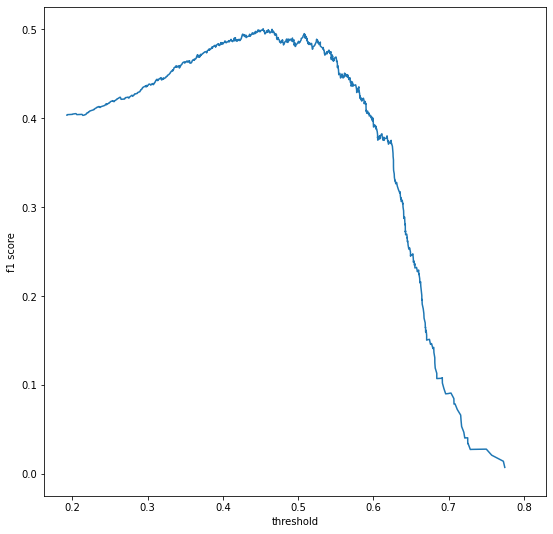

In [52]:
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
c_ax.plot(thresholds, f1_scores[1:])
c_ax.set_xlabel('threshold')
c_ax.set_ylabel('f1 score')

In [53]:
idx = np.nanargmax(f1_scores)
threshold = thresholds[idx]
threshold
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.37349397590361444
Recall is: 0.7587412587412588
Threshold is: 0.45371285
F1 Score is: 0.5005767012687428


In [65]:
# algorithmic limitations
threshold_final = 0.35808104 # threshold for high recall
pred_Y_class = (pred_Y > threshold_final).astype(int)
pred_Y_class
test['algorithm_output'] = pred_Y_class

In [66]:
other_deseases = ['Atelectasis', 'Effusion', 'Pneumothorax', 'Infiltration',
       'Cardiomegaly', 'Mass', 'Nodule']
for od in other_deseases:
    test_cond = test[test[od]==1]
    print(f'Combined with {od}')
    print(sklearn.metrics.classification_report(test_cond.Pneumonia,test_cond.algorithm_output))

Combined with Atelectasis
              precision    recall  f1-score   support

         0.0       0.53      0.10      0.16        94
         1.0       0.31      0.83      0.46        47

    accuracy                           0.34       141
   macro avg       0.42      0.46      0.31       141
weighted avg       0.46      0.34      0.26       141

Combined with Effusion
              precision    recall  f1-score   support

         0.0       0.90      0.10      0.18        90
         1.0       0.40      0.98      0.57        55

    accuracy                           0.43       145
   macro avg       0.65      0.54      0.37       145
weighted avg       0.71      0.43      0.33       145

Combined with Pneumothorax
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40        36
         1.0       0.23      1.00      0.37         8

    accuracy                           0.39        44
   macro avg       0.61      0.62      0.39        4

In [67]:
# example visualizations
test_X, test_Y = next(test_gen)
pred_Y = model.predict(test_X, verbose = True)
pred_Y = pred_Y.squeeze()

2/2 [==============================] - 0s 103ms/step


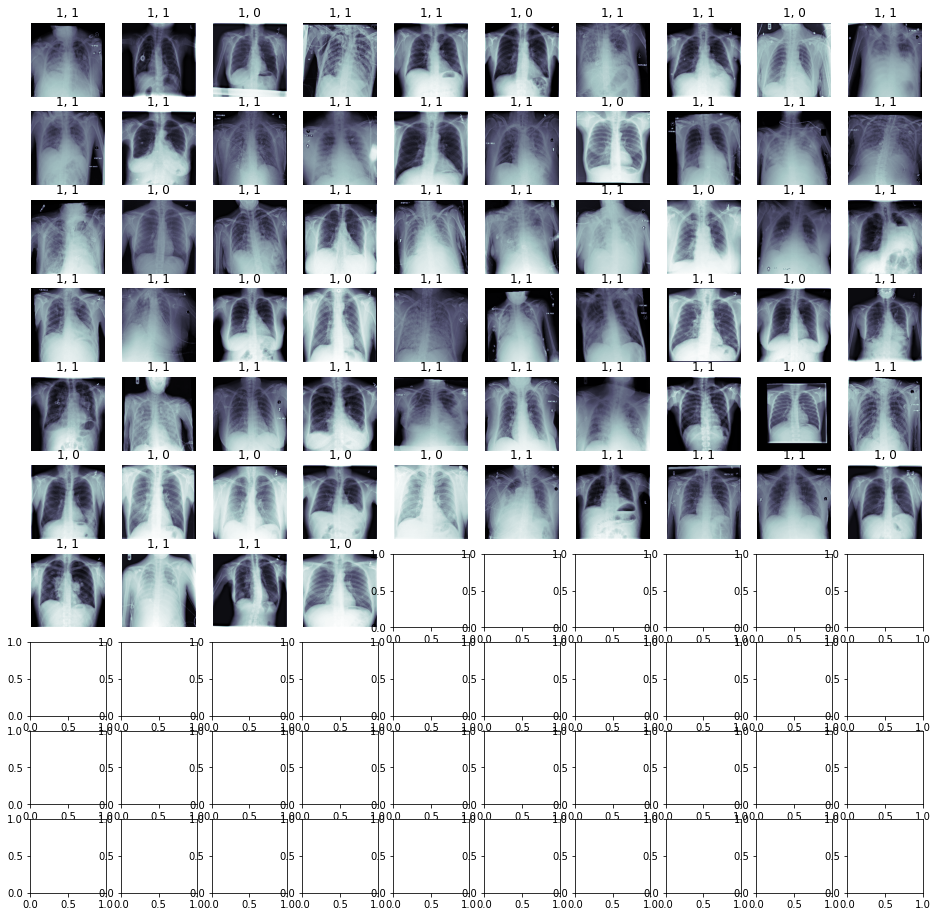

In [68]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(test_X[0:100], test_Y[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [69]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

## 